In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [123]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
    
    def init_layers(self):
        np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) * 0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        dZ[Z>0] = 1
        return dZ
    
    def linear_backward(self, dA, Z):
        return np.array(Z)
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        delta = y - y_predict
        loss = np.dot(delta, delta.T)
        return np.squeeze(loss)
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        m = A_prev.shape[1]
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)/m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/m
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*np.sum(y_predict-y)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            self.params['W'+str(layer_index)] -= self.learning_rate * grads_values['dW'+str(layer_index)]
            self.params['b'+str(layer_index)] -= self.learning_rate * grads_values['db'+str(layer_index)]
    
    def train(self, x, y, epochs, batch_size=16):
        self.init_layers()
        loss_history = []
        for i in range(epochs):
            #x, y = shuffle(x, y)
            #for i in range(0 ,x.shape[1], batch_size):
                #x_min = x[i:i + batch_size]
                #y_min = y[i:i + batch_size]
                #y_predict, memory = self.forward_propagation(x_min.T)
                #loss = self.get_loss_value(np.array([y_min]), y_predict)
                #grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                #self.update(grads_values)
            y_predict, memory = self.forward_propagation(x.T)
            print(memory['Z4'])
            loss = self.get_loss_value(np.array([y]), y_predict)
            grads_values = self.back_propagation(y_predict, np.array([y]), memory)
            self.update(grads_values)
            y_predict, memory = self.forward_propagation(x.T)
            loss = self.get_loss_value(np.array([y]), y_predict)
            print("the lost %lf" % loss)
            loss_history.append(loss)
        return loss_history
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return y_predict

In [124]:
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    #{"input_dim": 8, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.00001

In [125]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [126]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [127]:
# split data
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy(), heating.to_numpy(), test_size=0.25, random_state=42)

In [128]:
model = myNN(nn_architecture, learning_rate)
model.train(X_train, np.array(y_train), 1, batch_size=16)
print("finish")

[[-3.57830923e-01 -4.40877936e-01 -2.16892846e-01 -2.23233349e-01
  -4.34073607e-01 -4.09696364e-01 -4.74978203e-01 -1.63796894e-01
   3.77527800e-03 -8.00686082e-02 -3.60450017e-01 -3.60526731e-01
  -4.80631433e-01 -4.87299605e-01 -4.37085409e-01 -4.94562700e-01
  -4.17162171e-03 -3.60992844e-01 -4.78300727e-01 -3.56356608e-01
  -2.91708669e-01 -1.48173723e-01 -1.57411167e-01 -3.64774840e-01
  -3.04194622e-01 -4.22728755e-01 -2.19948060e-01 -4.75014606e-01
  -4.40371530e-01 -4.16270172e-01 -7.54000888e-01 -7.61917891e-01
  -1.17263137e-02 -7.67608283e-02 -7.56658348e-02  2.75348889e-03
  -3.70763699e-01 -4.71966401e-01 -4.84827967e-01 -4.09572994e-01
  -2.85716198e-01 -7.54838494e-01 -3.40491988e-01 -5.88834942e-03
  -7.57529029e-01 -2.91928042e-01 -4.34203008e-01 -4.91668699e-01
  -3.56570692e-01 -4.22482016e-01 -1.50422709e-01 -1.50982198e-01
  -4.12756867e-01 -2.29410289e-01 -4.15784838e-01 -3.60203278e-01
  -7.48207255e-01 -7.58501573e-02 -3.73259423e-01 -4.39930879e-01
  -2.92139

In [ ]:
y_predict = model.predict(X_test.T)
y_predict = np.squeeze(y_predict)

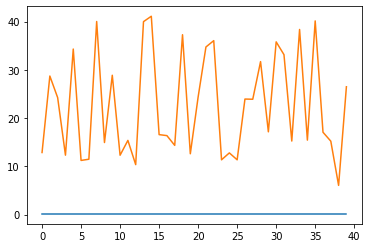

In [109]:
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_test[:40])
plt.show()

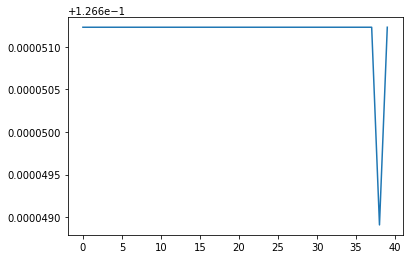

In [110]:
plt.plot(t[:40],y_predict[:40])
plt.show()

(16, 576)